# Model: GRU (Gated Recurrent Unit)  - Stock Token: FPT - Test/Train/Vaildation: 70/20/10
- Dataset: 1313 rows x 7 columns (01/03/2019 - 31/05/2024)
- Window-slide: 10, epochs: 200, batch-size: 32
----
### Model evaluation (Test set)
- RMSE: 1605.25
- MAE: 1119.29
- MAPE: 1.44 %

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

plt.style.use("default")

## 1. Data preprocessing


In [31]:
# Split: [0] = 70% 20% 10% | [1] = 60% 20% 20% | [2] = 80% 10% 10%
split_type = [[0.7, 0.2], [0.6, 0.2], [0.8, 0.1]]
# Stock [0] = FPT | [1] = CMG | [2] = ITD
stock_name = ["FPT", "CMG", "ITD"]

In [32]:
# Change stock and split to adjust between splitting type and stock
stock = 0  # FPT
split = 0  # 7 2 1

In [33]:
# Loading data
df = pd.read_csv(f"../../Dataset/{stock_name[stock]}_stock.csv")
df = df[["time", "close"]]
df["time"] = pd.to_datetime(df["time"])
df.set_index("time", inplace=True)

df

,close
time,
2019-03-01,19270
2019-03-04,19440
2019-03-05,19390
2019-03-06,19270
2019-03-07,19330
...,...
2024-05-27,132800
2024-05-28,137000
2024-05-29,135700


In [34]:
df.shape

(1313, 1)

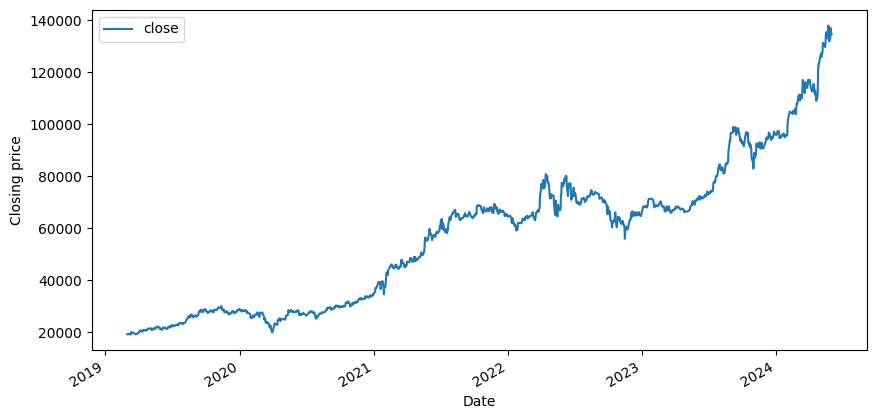

In [35]:
df.plot(figsize=(10, 5))
plt.ylabel("Closing price")
plt.xlabel("Date")
plt.show()

In [36]:
df = df.reset_index()["close"]
df

0        19270
1        19440
2        19390
3        19270
4        19330
         ...  
1308    132800
1309    137000
1310    135700
1311    135000
1312    134600
Name: close, Length: 1313, dtype: int64

In [37]:
# Normalize data between 0 and 1 because we using natural network model
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(np.array(df).reshape(-1, 1))

## 2. Model training


### Create train set, test set, validation set and reshape them


In [38]:
# Defining the split size
train_size = int(split_type[split][0] * len(df_scaled))
test_size = int(split_type[split][1] * len(df_scaled))
val_size = len(df) - train_size - test_size

In [39]:
# Splitting data into train, test and validation set
train_data = df_scaled[:train_size]
test_data = df_scaled[train_size : train_size + test_size]
val_data = df_scaled[train_size + test_size :]

In [40]:
# Function to create dataset input and output, it will convert an array of values into a dataset matrix, use the sliding window with the time_step argument
def create_dataset(data, window_side):
    X, y = [], []

    for i in range(len(data) - window_side - 1):
        X.append(data[i : (i + window_side), 0])
        y.append(data[i + window_side, 0])

    return np.array(X), np.array(y)

In [41]:
# Define time step, it mean the model will take 10 days before to predict the closing price 'at that time'
WINDOW_SIDE = 10

# Create X, y for train, test and validate
X_train, y_train = create_dataset(train_data, WINDOW_SIDE)
X_test, y_test = create_dataset(test_data, WINDOW_SIDE)
X_val, y_val = create_dataset(val_data, WINDOW_SIDE)

X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape

((908, 10), (908,), (251, 10), (251,), (121, 10), (121,))

In [42]:
# Reshape the dataset to suit the RNN input
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)

### Start train model


In [43]:
from keras.models import Sequential
from keras.layers import Dense, GRU, Dropout, Input

# Initialize LSTM model
model = Sequential(
    [
        Input((X_train.shape[1], 1)),
        GRU(100),
        Dense(32, activation="relu"),
        Dense(1),  # activation default is linear
    ]
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_1 (GRU)                     │ (None, 100)            │        30,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         3,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,165 (133.46 KB)

 Trainable params: 34,165 (133.46 KB)

 Non-trainable params: 0 (0.00 B)

In [44]:
model.compile(optimizer="adam", loss="mse", metrics=["mean_absolute_error"])

In [45]:
EPOCHS = 200
BATCH_SIZE = 32
VERBOSE = 1

# Train the model
model.fit(
    X_train,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_test, y_test),
)

Epoch 1/200


29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0275 - mean_absolute_error: 0.1184 - val_loss: 0.0030 - val_mean_absolute_error: 0.0513
Epoch 2/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1263e-04 - mean_absolute_error: 0.0153 - val_loss: 4.9174e-04 - val_mean_absolute_error: 0.0187
Epoch 3/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.4579e-04 - mean_absolute_error: 0.0086 - val_loss: 1.8749e-04 - val_mean_absolute_error: 0.0097
Epoch 4/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1248e-04 - mean_absolute_error: 0.0071 - val_loss: 1.6399e-04 - val_mean_absolute_error: 0.0089
Epoch 5/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2183e-04 - mean_absolute_error: 0.0071 - val_loss: 1.8216e-04 - val_mean_absolute_error: 0.0095
Epoch 6/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.6206e-05 - mean_absolute_error: 0.0066 - val_loss: 1.5788e-04 - val_mean_absolute_error: 0.0088
Epoch 7/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.2342e-05 - mean_a

### Predicting with test set and validate set


In [46]:
# Predict and convert the data back - because i reshaped between 0 and 1, so need to convert back
y_pred_test = model.predict(X_test)
y_pred_test = scaler.inverse_transform(y_pred_test)

y_pred_val = model.predict(X_val)
y_pred_val = scaler.inverse_transform(y_pred_val)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step


## 3. Model evaluation


In [47]:
# Evaluate the model on test data
loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.5690e-05 - mean_absolute_error: 0.0058 
Test Loss: [9.73781498032622e-05, 0.006638267543166876]


In [48]:
# Splitting data into train, test and validation set again to evaluate, because i shaped the data between 0 and 1 to suit the model
train_data1 = df[:train_size]
test_data1 = df[train_size : train_size + test_size]
val_data1 = df[train_size + test_size :]

X_test1 = np.array(test_data1.index).reshape(-1, 1)
y_test1 = np.array(test_data1)

X_val1 = np.array(val_data1.index).reshape(-1, 1)
y_val1 = np.array(val_data1)

In [49]:
print(len(y_test))
print(len(y_test1))

251
262


In [50]:
# Evaluation
from sklearn.metrics import (
    mean_absolute_percentage_error as mape,
    mean_squared_error as mse,
    mean_absolute_error as mae,
)


def evalute_model(y, y_pred):
    # Because i use the sliding window with the time_step value, so the length of 'y' and 'y predict' will difference
    min_len = min(len(y), len(y_pred))
    y = y[-min_len:]
    y_pred = y_pred[-min_len:]

    print(f"MSE: {mse(y, y_pred)}")
    print(f"RMSE: {np.sqrt(mse(y, y_pred))}")
    print(f"MAE: {mae(y, y_pred)}")
    print(f"MAPE: {mape(y, y_pred) * 100} %")

In [51]:
# So the result will change every time RUN ALL (build model again), because the model will take random start number.
# But it dont change much, the MAPE will less than 2 %(test set)
# Model evaluation on test set
print("Model evalution on test set")
evalute_model(y_test1, y_pred_test)

print("")
# Model evaluation on validate set
print("Model evalution on validate set")
evalute_model(y_val1, y_pred_val)

Model evalution on test set
MSE: 2576842.3205590113
RMSE: 1605.254596803576
MAE: 1119.296952813745
MAPE: 1.444031317246893 %

Model evalution on validate set
MSE: 11994794.487783385
RMSE: 3463.3501826675547
MAE: 2538.961970557851
MAPE: 2.213739187095095 %


## 4. Forecast the next 30/60/90 days


In [52]:
def forecast(data, window_side, forecast_days):
    # Get the last sequence_length days
    x_forecast = data[-window_side:]
    y_forecast = []

    for i in range(forecast_days + 1):
        # Reshape x_forecast to have the shape (1, window_side, num_features)
        x_forecast_reshaped = x_forecast.reshape(1, window_side, x_forecast.shape[1])
        # Predict the next day
        y = model.predict(x_forecast_reshaped)
        y_forecast.append(y[0][0])

        # Add the new prediction to the data
        x_forecast = np.insert(x_forecast, -1, y, axis=0)[1:]

    return y_forecast

In [53]:
y_pred_30_days = forecast(val_data, 5, 30)

# Assuming y_pred_30_days is a 1D array
y_pred_30_days = np.array(y_pred_30_days).reshape(-1, 1)

# Inverse transform y_pred_30_days
y_pred_30_days = scaler.inverse_transform(y_pred_30_days)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

In [54]:
y_pred_30_days

array([[132012.86],
       [132563.8 ],
       [132116.  ],
       [132327.72],
       [132187.1 ],
       [132257.44],
       [132216.77],
       [132239.72],
       [132226.58],
       [132233.94],
       [132229.75],
       [132232.12],
       [132230.78],
       [132231.55],
       [132231.1 ],
       [132231.36],
       [132231.22],
       [132231.27],
       [132231.25],
       [132231.25],
       [132231.25],
       [132231.25],
       [132231.25],
       [132231.25],
       [132231.25],
       [132231.25],
       [132231.25],
       [132231.25],
       [132231.25],
       [132231.25],
       [132231.25]], dtype=float32)

### Continute predict the next 60/90 days


In [55]:
y_pred_60_days = forecast(val_data, 5, 60)
y_pred_60_days = np.array(y_pred_60_days).reshape(-1, 1)
y_pred_60_days = scaler.inverse_transform(y_pred_60_days)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━

In [56]:
y_pred_90_days = forecast(val_data, 5, 90)
y_pred_90_days = np.array(y_pred_90_days).reshape(-1, 1)
y_pred_90_days = scaler.inverse_transform(y_pred_90_days)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━

### Plot the data


In [57]:
def draw_plot(y_days_predict, days):
    plt.figure(figsize=(16, 9))
    plt.ylabel("Closing Price")

    # Raw data
    plt.plot(train_data1.index, train_data1, label="Train")
    plt.plot(test_data1.index, test_data1, label="Test")
    plt.plot(val_data1.index, val_data1, label="Validate")

    # Predict test and validate
    plt.plot(
        test_data1.index[
            WINDOW_SIDE : len(y_pred_test) + WINDOW_SIDE
        ],  # because using the sliding window (WINDOW_SIDE) -> the index of 2 dataset is difference
        y_pred_test,
        label="Predicted Test",
        linestyle="--",
    )
    plt.plot(
        val_data1.index[WINDOW_SIDE : len(y_pred_val) + WINDOW_SIDE],
        y_pred_val,
        label="Predicted Validate",
        linestyle="--",
    )

    # Predict the next 30/60/90 days
    plt.plot(
        val_data1.index[-1] + np.arange(1, len(y_days_predict) + 1),
        y_days_predict,
        label=f"Next {days} Days",
        linestyle="--",
    )

    plt.title(f"{stock_name[stock]} Stock Closing Price Forecasting Using GRU")
    plt.legend()
    plt.show()

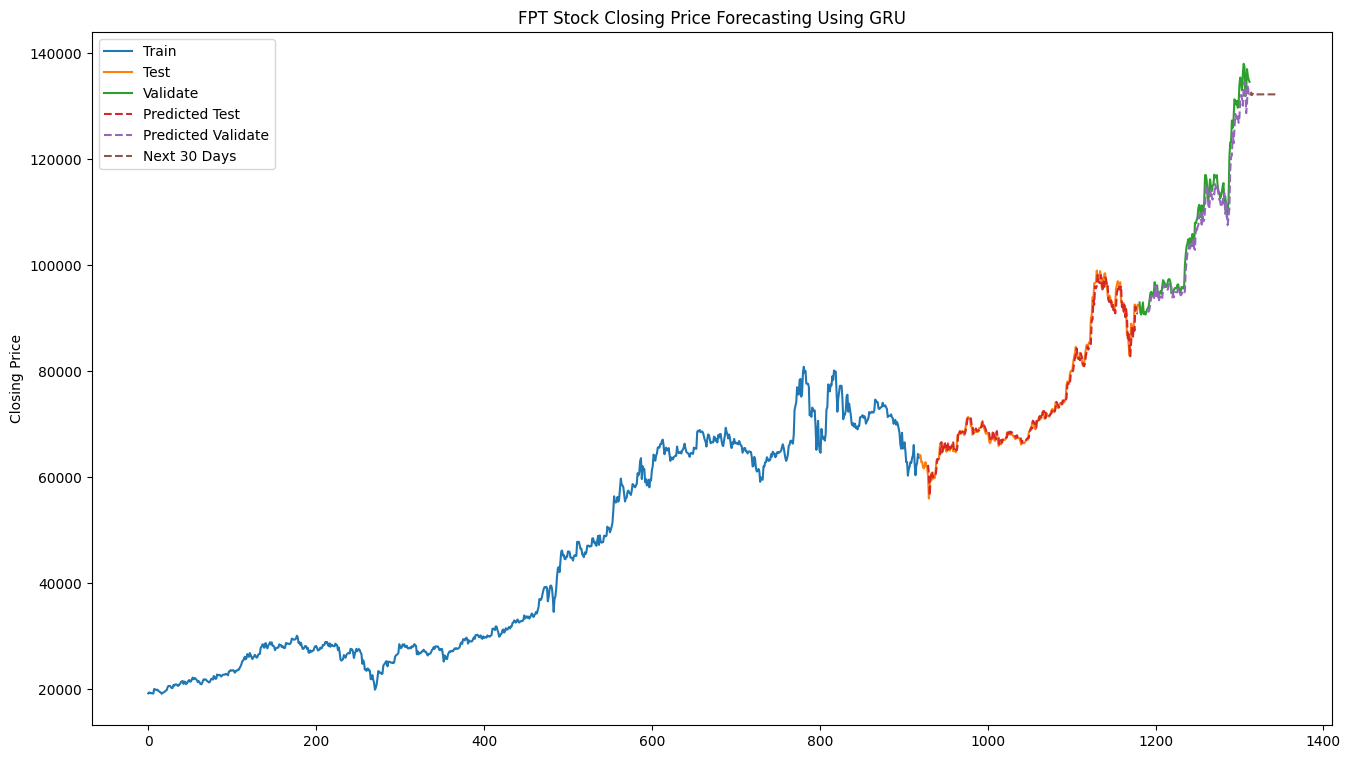

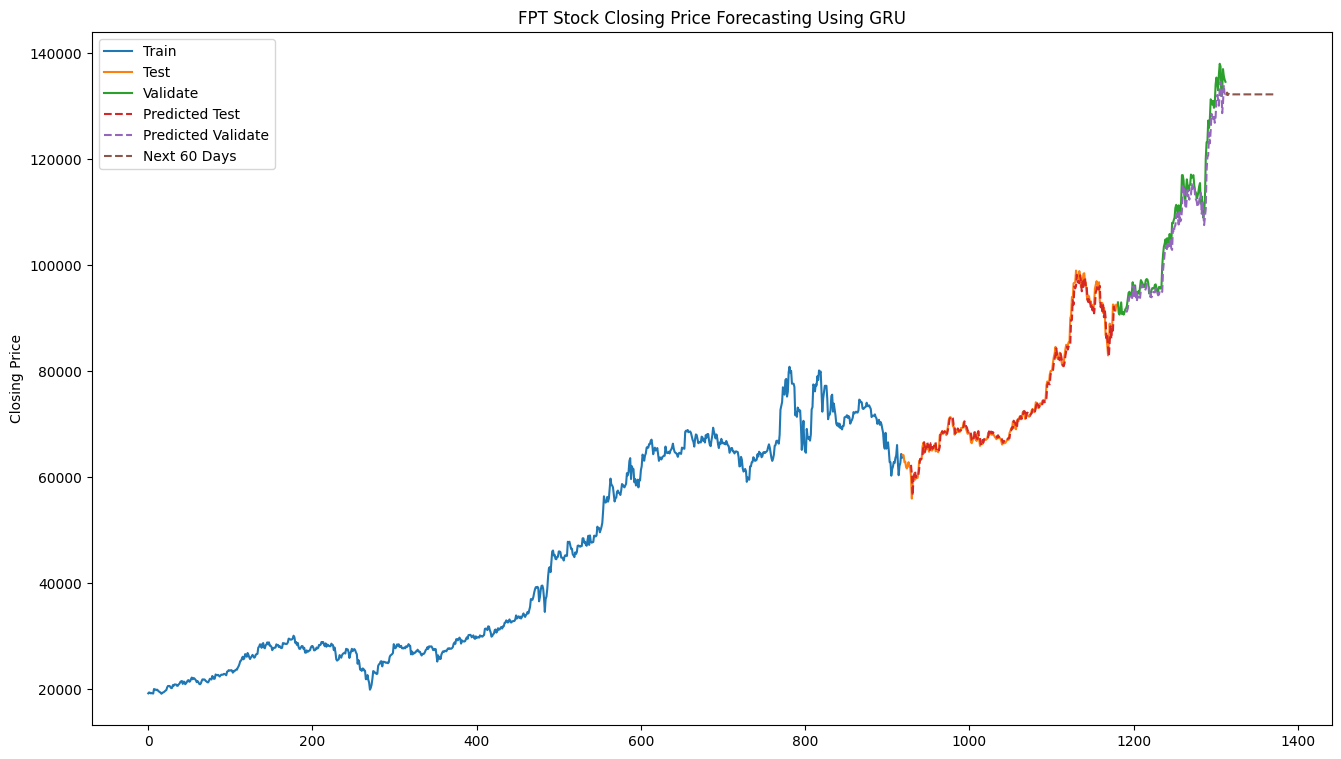

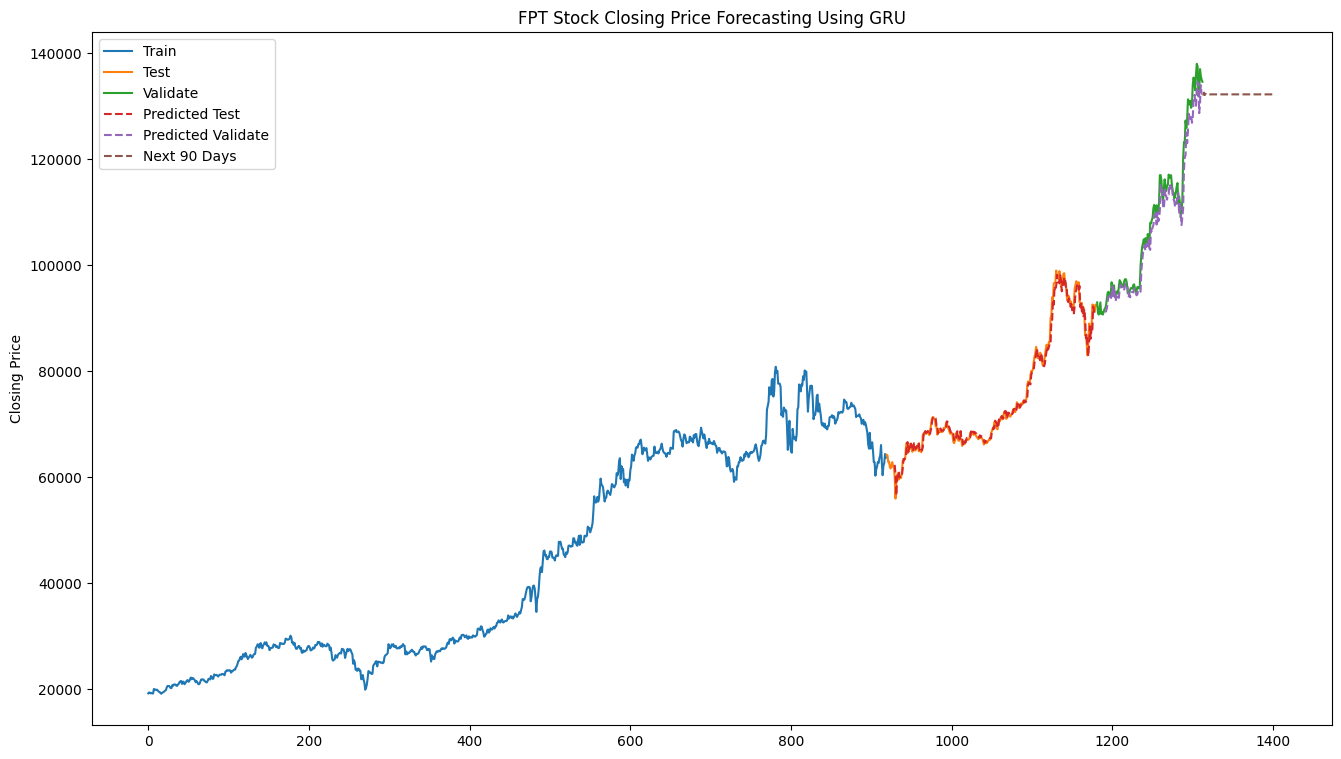

In [58]:
draw_plot(y_pred_30_days, 30)
draw_plot(y_pred_60_days, 60)
draw_plot(y_pred_90_days, 90)